# Support Vector Machines


In [ ]:
import os
from skimage.feature import hog
from skimage import exposure
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix
import cv2

import seaborn as sns
import matplotlib.pyplot as plt




In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
base_path = '/content/drive/.shortcut-targets-by-id/1W01KwNde9fWkWs9206tNtZsdc3BVs97m/anomaly/mvtec_anomaly_detection/'


In [ ]:
# Define the HOG parameters
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
fixed_length = 352836


In [ ]:
# Initialize lists to store HOG features and labels for training data
hog_features_train = []
labels_train = []


In [ ]:
# Specify the list of classes (folders)
classes = ["zipper", "wood", "transistor", "toothbrush", "tile", "screw", "pill", "metal_nut", "leather", "hazelnut", "grid", "carpet", "capsule", "cable", "bottle"]


In [ ]:
def load_and_preprocess_image(image_path, target_size=(180, 180)):
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    # Resize the image to the target size
    image = cv2.resize(image, target_size)
    # Normalize the pixel values to the [0, 1] range
    image = image.astype("float32") / 255.0
    return image

In [ ]:
# HOG features and labels for test data
for class_name in classes:
    train_folder = os.path.join(base_path, class_name, "train", "good")

    for filename in os.listdir(train_folder):
        image_path = os.path.join(train_folder, filename)
        image = load_and_preprocess_image(image_path, target_size=(180, 180))

        features = hog(image, orientations=orientations,
                       pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block,
                       block_norm='L2-Hys',
                       visualize=False,
                       multichannel=True)

        if len(features) < fixed_length:
            features = np.pad(features, (0, fixed_length - len(features)))
        elif len(features) > fixed_length:
            features = features[:fixed_length]

        hog_features_train.append(features)
        labels_train.append(1)

hog_features_train = np.array(hog_features_train)
labels_train = np.array(labels_train)

<ipython-input-27-f460968fcb34>:10: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features = hog(image, orientations=orientations,


In [ ]:
# Check dimensions of features
distinct_dimensions = set()

for features in hog_features_train:
    dimension = features.shape
    distinct_dimensions.add(dimension)


for dim in distinct_dimensions:
    print(dim)

print(len(hog_features_train))



(352836,)
3629


In [ ]:
# Initialize the SVM classifier
clf = svm.OneClassSVM(kernel='rbf', gamma='scale')

# Train the classifier on the training data
clf.fit(hog_features_train)

OneClassSVM()

In [ ]:
# HOG features and labels for test data
hog_features_test = []
labels_test = []

for class_name in classes:
    test_folder = os.path.join(base_path, class_name, "test")

    for folder_name in os.listdir(test_folder):
        defect_folder = os.path.join(test_folder, folder_name)

        for filename in os.listdir(defect_folder):
            image_path = os.path.join(defect_folder, filename)
            image = load_and_preprocess_image(image_path, target_size=(180, 180))


            features = hog(image, orientations=orientations,
                           pixels_per_cell=pixels_per_cell,
                           cells_per_block=cells_per_block,
                           block_norm='L2-Hys',
                           visualize=False,
                           multichannel=True)


            if len(features) < fixed_length:
                features = np.pad(features, (0, fixed_length - len(features)))
            elif len(features) > fixed_length:
                features = features[:fixed_length]

            hog_features_test.append(features)

            if folder_name == "good":
                labels_test.append(1)
            else:
                labels_test.append(-1)

hog_features_test = np.array(hog_features_test)
labels_test = np.array(labels_test)


<ipython-input-32-ea4eec799be3>:16: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features = hog(image, orientations=orientations,


In [ ]:
# Check dimensions of features
distinct_dimensions_test = set()

for features in hog_features_test:
    dimension_test = features.shape
    distinct_dimensions_test.add(dimension)


for dim in distinct_dimensions_test:
    print(dim)

print(len(hog_features_test))


(352836,)
1725


In [ ]:
y_pred = clf.predict(hog_features_test)

In [ ]:
accuracy = accuracy_score(labels_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 49.28%


In [ ]:
# Baseline Model - Calculate accuracy by comparing simple rule labels with ground truth labels
# Simple rule - Each picture in test folder is defective
simple_rule_labels = np.full_like(labels_test, -1)
accuracy = accuracy_score(labels_test, simple_rule_labels)
print(f"Accuracy using the simple rule: {accuracy * 100:.2f}%")

Accuracy using the simple rule: 72.93%


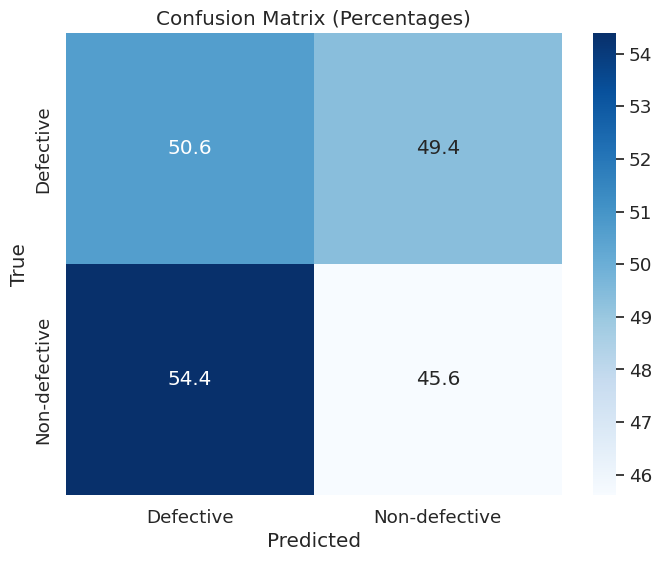

In [ ]:
# Confusion matrix for SVM model
cm = confusion_matrix(labels_test, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm_percentage, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=["Defective", "Non-defective"],
            yticklabels=["Defective", "Non-defective"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentages)')
plt.show()